# Import Libraries

In [22]:
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, plot_confusion_matrix, confusion_matrix
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, Input, Bidirectional, LSTM, Conv1D
from tensorflow.keras.layers import MaxPool1D, Dropout, Flatten, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

# Download and Load Stopwords

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.remove('not')

# Import Dataset and select required columns

In [26]:
dataset = pd.read_csv('labeled_data.csv')

In [27]:
dataset.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Drop Unwanted columns from dataset

In [28]:
data = dataset.iloc[:,-2:]

In [29]:
data.head(5)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Checking Class Labels

In [30]:
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

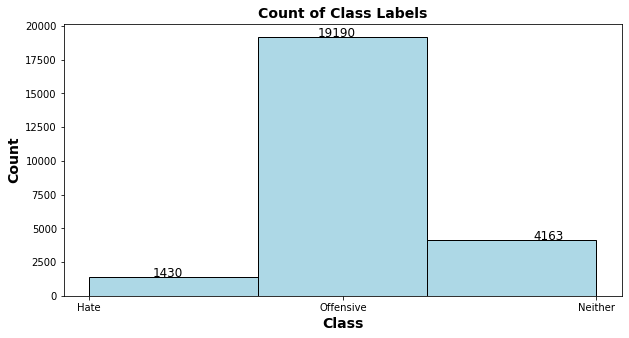

In [31]:
c0 = data['class'].value_counts()[0]
c1 = data['class'].value_counts()[1]
c2 = data['class'].value_counts()[2]
plt.figure(figsize=(10,5))
plt.hist(data['class'], bins = 3, color = 'lightblue', edgecolor = 'black')
plt.xlabel('Class', fontsize = 14, fontweight = 'bold')
plt.ylabel('Count', fontsize = 14, fontweight = 'bold')
plt.title('Count of Class Labels', fontsize = 14, fontweight = 'bold')
plt.xticks([0,1,2],['Hate', 'Offensive', 'Neither'])
plt.text(0.25,c0, str(c0), fontsize=12)
plt.text(0.9,c1, str(c1),fontsize=12)
plt.text(1.75,c2, str(c2),fontsize=12)
plt.show()

# Data Cleaning and Feature Selection

### Create Stemming Object

In [32]:
ps = PorterStemmer()

### Dictionary for Clitics Separation

In [33]:
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "cause": "because", 
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he shall",
    "he'll've": "he shall have",
    "he's": "he has",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has",
    "i'd": "I had",
    "i'd've": "I would have",
    "i'll": "I shall",
    "i'll've": "I shall have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it shall",
    "it'll've": "it shall have",
    "it's": "it has",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she shall",
    "she'll've": "she shall have",
    "she's": "she has",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there has",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they shall",
    "they'll've": "they shall have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall",
    "what'll've": "what shall have",
    "what're": "what are",
    "what's": "what has",
    "what've": "what have",
    "when's": "when has",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has",
    "where've": "where have",
    "who'll": "who shall",
    "who'll've": "who shall have",
    "who's": "who has",
    "who've": "who have",
    "why's": "why has",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you shall",
    "you'll've": "you shall have",
    "you're": "you are",
    "you've": "you have",
    "that's": "that is",
    "ya": "you",
    "im": "I am"}

### Create Corpus of Words

In [34]:
corpus = []
for i in range(0, len(data)):
    #Convert to Lower case
    tweet = data['tweet'][i].lower()
    
    #Remove Usernames
    tweet = re.sub('@[\w]+','',tweet)
    
    #Remove URL
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                    '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    
    #Split Clitics
    tweet = tweet.split()
    for j in range(0,len(tweet)):
      if tweet[j] in contractions.keys():
        tweet[j] = contractions[tweet[j]]
    tweet = ' '.join(tweet)

    #Remove Numbers and Special Characters
    tweet = re.sub('[^a-zA-Z]', ' ', tweet).strip()

    #Tokenization and Stemming words
    tweet = tweet.split()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords)]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

### Create Bag of Words using TfidfVectorizer

In [ ]:
tf = TfidfVectorizer(max_features=5000)
x = tf.fit_transform(corpus).toarray()

In [ ]:
y = data.iloc[:, 0].values

### Split data into Train and Test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Machine Learning Models

## Logistic Regression

In [ ]:
LR_classifier = LogisticRegression(random_state = 0, n_jobs = -1)
CV_LR = cross_val_score(LR_classifier, x_train, y_train,cv = 5, n_jobs = -1)
CV_LR.mean()

0.9002530715698903

### Fitting Training Data

In [ ]:
LR_classifier.fit(x_train,y_train)

LogisticRegression(n_jobs=-1, random_state=0)

### Confusion Matrix

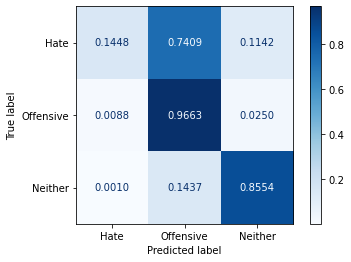

In [ ]:
plot_confusion_matrix(LR_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

### Classification Report

In [ ]:
y_pred_LR = LR_classifier.predict(x_test)
print(classification_report(y_test, y_pred_LR, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.55      0.14      0.23       359
   Offensive       0.92      0.97      0.94      4800
     Neither       0.85      0.86      0.85      1037

    accuracy                           0.90      6196
   macro avg       0.77      0.66      0.67      6196
weighted avg       0.88      0.90      0.89      6196



## Random Forest

In [ ]:
RF_classifier = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
CV_RF = cross_val_score(RF_classifier, x_train, y_train, cv = 5, n_jobs = -1)
CV_RF.mean()

0.9068706174312432

### Fitting Training Data

In [ ]:
RF_classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

### Confusion Matrix

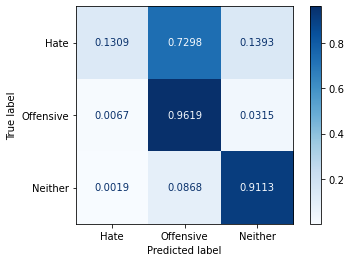

In [ ]:
plot_confusion_matrix(RF_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

### Classification Report

In [ ]:
y_pred_RF = RF_classifier.predict(x_test)
print(classification_report(y_test, y_pred_RF, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.58      0.13      0.21       359
   Offensive       0.93      0.96      0.95      4800
     Neither       0.82      0.91      0.87      1037

    accuracy                           0.91      6196
   macro avg       0.78      0.67      0.67      6196
weighted avg       0.89      0.91      0.89      6196



## Linear SVM

In [ ]:
LSVM_classifier = LinearSVC(random_state = 0, max_iter = 100000)
params = {'C' : [0.1,1,10,100]}
gcv_lsvm = GridSearchCV(LSVM_classifier, params, cv = 5, n_jobs = -1)
gcv_lsvm.fit(x_train,y_train)
print('Best Score : ', gcv_lsvm.best_score_)
print('Best Parameters : ', gcv_lsvm.best_params_)

Best Score :  0.8940659369603307
Best Parameters :  {'C': 1}


### Fitting Training Data

In [ ]:
LSVM_classifier = LinearSVC(C = 1 , random_state = 0)
LSVM_classifier.fit(x_train, y_train)

LinearSVC(C=1, random_state=0)

### Confusion Matrix

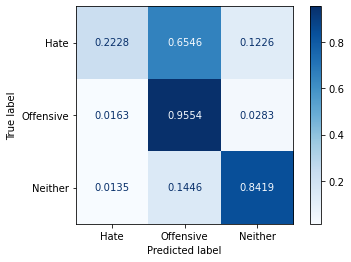

In [ ]:
plot_confusion_matrix(LSVM_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

### Classification Report

In [ ]:
y_pred_LSVM = LSVM_classifier.predict(x_test)
print(classification_report(y_test, y_pred_LSVM, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.47      0.22      0.30       359
   Offensive       0.92      0.96      0.94      4800
     Neither       0.83      0.84      0.84      1037

    accuracy                           0.89      6196
   macro avg       0.74      0.67      0.69      6196
weighted avg       0.88      0.89      0.88      6196



## Kernel SVM

In [ ]:
KSVM_classifier = SVC(kernel = 'rbf', random_state = 0)
CV_KSVM = cross_val_score(KSVM_classifier, x_train, y_train, cv = 5, n_jobs = -1)
CV_KSVM.mean()

0.9036963471122533

### Fitting Training Data

In [ ]:
KSVM_classifier.fit(x_train, y_train)

SVC(random_state=0)

### Confusion Matrix

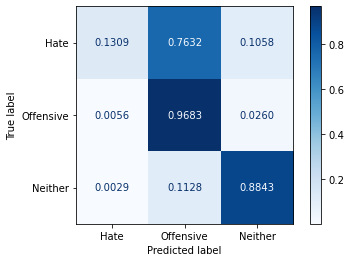

In [ ]:
plot_confusion_matrix(KSVM_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

### Classification Report

In [ ]:
y_pred_KSVM = KSVM_classifier.predict(x_test)
print(classification_report(y_test, y_pred_KSVM, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.61      0.13      0.22       359
   Offensive       0.92      0.97      0.94      4800
     Neither       0.85      0.88      0.87      1037

    accuracy                           0.91      6196
   macro avg       0.79      0.66      0.68      6196
weighted avg       0.89      0.91      0.89      6196



# Deep Learning Models

## Data Pre-Processing

In [ ]:
corpus_d = []
for i in range(0, len(data)):
    #Convert to Lower case
    tweet = data['tweet'][i].lower()
    
    #Remove Usernames
    tweet = re.sub('@[\w]+','',tweet)
    
    #Remove URL
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                    '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    
    #Split Clitics
    tweet = tweet.split()
    for j in range(0,len(tweet)):
      if tweet[j] in contractions.keys():
        tweet[j] = contractions[tweet[j]]
    tweet = ' '.join(tweet)

    #Remove Numbers and Special Characters
    tweet = re.sub('[^a-zA-Z]', ' ', tweet).strip()
    tweet = tweet.split()
    tweet = ' '.join(tweet)

    corpus_d.append(tweet)

In [ ]:
x_d = corpus_d
y_d = data['class']

In [ ]:
x_train_d, x_test_d, y_train_d, y_test_d = train_test_split(x_d, y_d, test_size = 0.25, random_state = 0)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_d)

In [ ]:
max_len = max([len(s.split()) for s in x_d])
vocab_size = len(tokenizer.word_index) + 1
print(max_len, vocab_size)

35 20019


In [ ]:
x_train_d = tokenizer.texts_to_sequences(x_train_d)
x_train_d = pad_sequences(x_train_d, maxlen = max_len, padding = 'post', value = 0)
x_test_d = tokenizer.texts_to_sequences(x_test_d)
x_test_d = pad_sequences(x_test_d, maxlen = max_len, padding = 'post', value = 0)

## Random Embeddings

### CNN

In [ ]:
inputs1 = Input(shape = (max_len,))
embedding1 = Embedding(input_dim = vocab_size, output_dim = 50,
                       embeddings_initializer="uniform", mask_zero = True)(inputs1)
conv1 = Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(embedding1)
pool1 = MaxPool1D(pool_size = 2)(conv1)
drop1 = Dropout(0.2)(pool1)
flat1 = Flatten()(drop1)

inputs2 = Input(shape = (max_len,))
embedding2 = Embedding(input_dim = vocab_size, output_dim = 50, 
                       embeddings_initializer="uniform",mask_zero = True)(inputs2)
conv2 = Conv1D(filters = 32, kernel_size = 4, activation = 'relu')(embedding2)
pool2 = MaxPool1D(pool_size = 2)(conv2)
drop2 = Dropout(0.2)(pool2)
flat2 = Flatten()(drop2)

inputs3 = Input(shape = (max_len,))
embedding3 = Embedding(input_dim = vocab_size, output_dim = 50, 
                       embeddings_initializer="uniform",mask_zero = True)(inputs3)
conv3 = Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(embedding3)
pool3 = MaxPool1D(pool_size = 2)(conv3)
drop3 = Dropout(0.2)(pool3)
flat3 = Flatten()(drop3)

merge = Concatenate()([flat1,flat2,flat3])
hidden1 = Dense(units = 10, activation = 'relu')(merge)
hidden2 = Dense(units = 6, activation = 'relu')(hidden1)
output = Dense(units = 3, activation = 'softmax')(hidden2)

cnn = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)

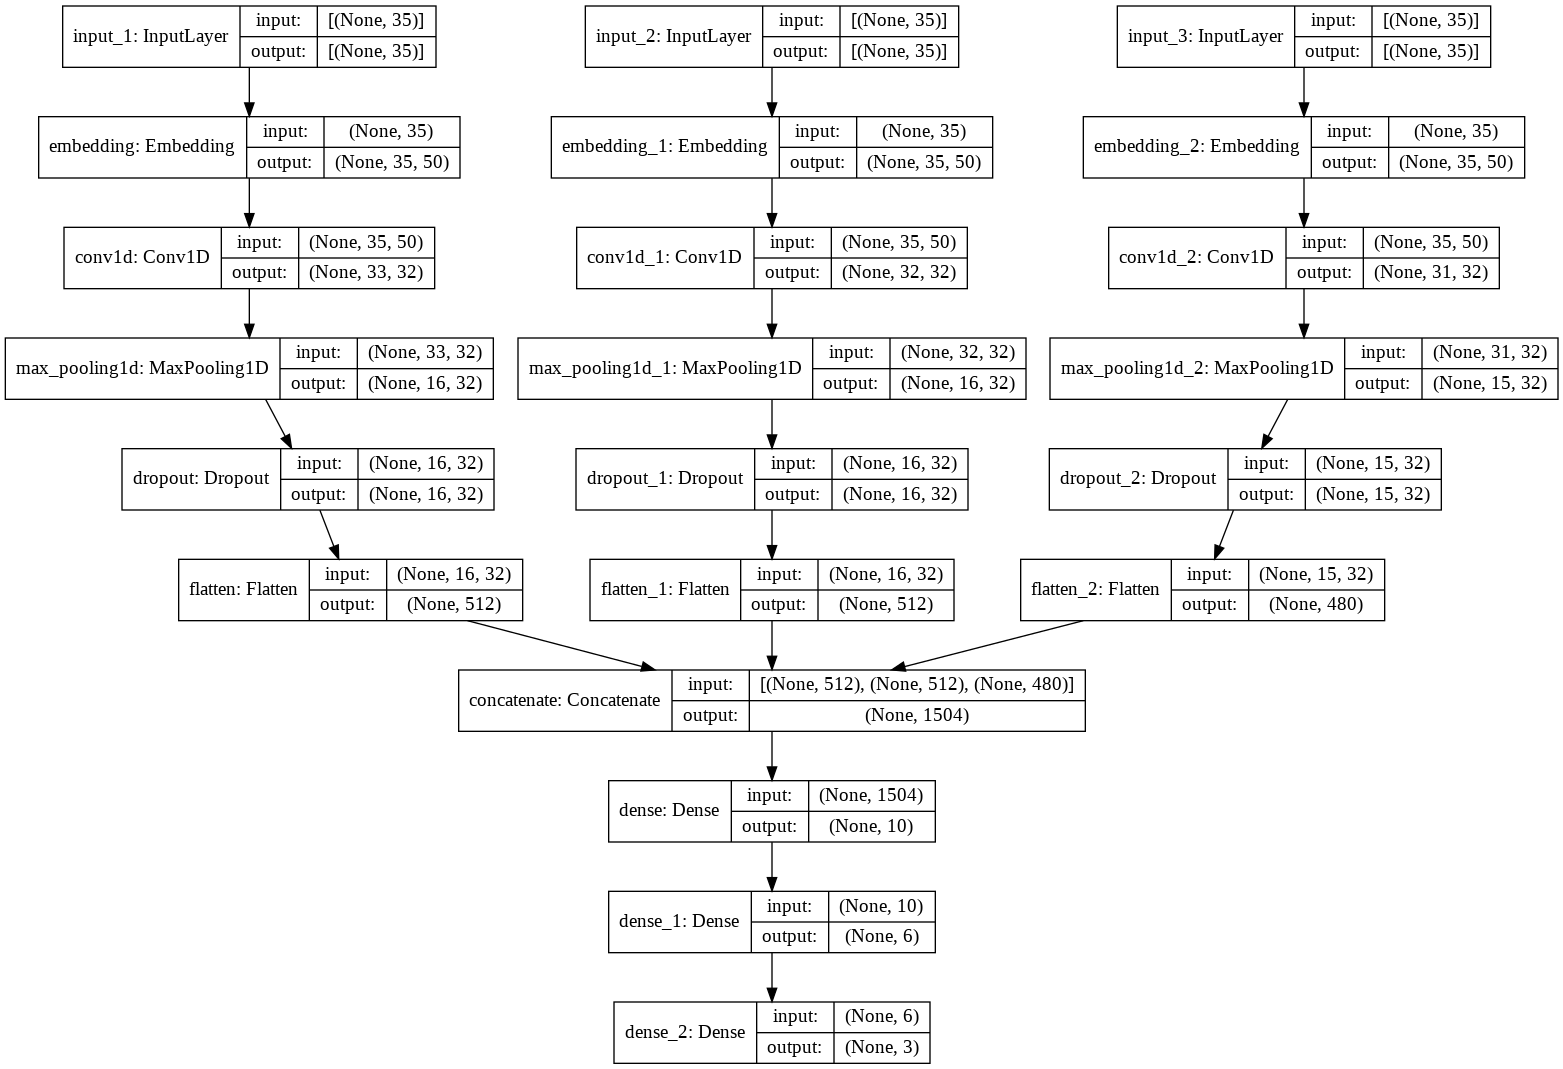

In [ ]:
plot_model(cnn, show_shapes=True)

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn.fit([x_train_d, x_train_d, x_train_d], y_train_d, epochs = 3, batch_size = 32)

Epoch 1/3
581/581 [==============================] - 10s 15ms/step - loss: 0.5307 - accuracy: 0.8117
Epoch 2/3
581/581 [==============================] - 9s 15ms/step - loss: 0.2117 - accuracy: 0.9273
Epoch 3/3
581/581 [==============================] - 9s 16ms/step - loss: 0.1057 - accuracy: 0.9632


In [ ]:
y_pred_cnn = cnn.predict([x_test_d, x_test_d, x_test_d])
y_pred_cnn = [list(i).index(max(i)) for i in y_pred_cnn]
accuracy_cnn = accuracy_score(y_test_d, y_pred_cnn)
accuracy_cnn

0.8862169141381536

In [ ]:
cm_cnn = confusion_matrix(y_test_d, y_pred_cnn, normalize = 'true')
cm_cnn

array([[0.22284123, 0.70752089, 0.06963788],
       [0.01854167, 0.96145833, 0.02      ],
       [0.0144648 , 0.21793635, 0.76759884]])

In [ ]:
print(classification_report(y_test_d, y_pred_cnn, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.43      0.22      0.29       359
   Offensive       0.91      0.96      0.93      4800
     Neither       0.87      0.77      0.81      1037

    accuracy                           0.89      6196
   macro avg       0.74      0.65      0.68      6196
weighted avg       0.87      0.89      0.88      6196



### RNN

In [ ]:
rnn = Sequential()
rnn.add(Input(shape = (max_len,)))
rnn.add(Embedding(input_dim = vocab_size, output_dim = 50,
                  embeddings_initializer="uniform", mask_zero = True))
rnn.add(Bidirectional(LSTM(50, return_sequences=True)))
rnn.add(Dropout(0.2))
rnn.add(Bidirectional(LSTM(50, return_sequences=False)))
rnn.add(Dropout(0.2))
rnn.add(Dense(units = 3, activation = 'softmax'))

In [ ]:
rnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
rnn.fit(x_train_d, y_train_d, epochs = 3, batch_size = 32)

Epoch 1/3
581/581 [==============================] - 33s 42ms/step - loss: 0.5271 - accuracy: 0.8298
Epoch 2/3
581/581 [==============================] - 24s 42ms/step - loss: 0.2090 - accuracy: 0.9333
Epoch 3/3
581/581 [==============================] - 24s 42ms/step - loss: 0.1288 - accuracy: 0.9565


In [ ]:
y_pred_rnn = rnn.predict(x_test_d)
y_pred_rnn = [list(i).index(max(i)) for i in y_pred_rnn]
accuracy_rnn = accuracy_score(y_test_d, y_pred_rnn)
accuracy_rnn

0.8878308586184636

In [ ]:
cm_rnn = confusion_matrix(y_test_d, y_pred_rnn, normalize = 'true')
cm_rnn

array([[0.27855153, 0.62674095, 0.09470752],
       [0.02208333, 0.94875   , 0.02916667],
       [0.01157184, 0.17164899, 0.81677917]])

In [ ]:
print(classification_report(y_test_d, y_pred_rnn, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.46      0.28      0.35       359
   Offensive       0.92      0.95      0.93      4800
     Neither       0.83      0.82      0.82      1037

    accuracy                           0.89      6196
   macro avg       0.74      0.68      0.70      6196
weighted avg       0.88      0.89      0.88      6196



## Pretrained WordVec(GloVe)

In [35]:
embeddings_index = {}
with open('glove.6B.50d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [102]:
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        embedding_matrix[i] = np.random.uniform(-1, 1, (1,50))
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15646 words (4372 misses)


### CNN

In [103]:
Embeddings = Embedding(vocab_size, 50, weights=[embedding_matrix],
                            input_length = max_len,
                            trainable=True, mask_zero = True)

In [104]:
inputs1 = Input(shape = (max_len,))
embedding1 = Embeddings(inputs1)
conv1 = Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(embedding1)
pool1 = MaxPool1D(pool_size = 2)(conv1)
drop1 = Dropout(0.2)(pool1)
flat1 = Flatten()(drop1)

inputs2 = Input(shape = (max_len,))
embedding2 = Embeddings(inputs2)
conv2 = Conv1D(filters = 32, kernel_size = 4, activation = 'relu')(embedding2)
pool2 = MaxPool1D(pool_size = 2)(conv2)
drop2 = Dropout(0.2)(pool2)
flat2 = Flatten()(drop2)

inputs3 = Input(shape = (max_len,))
embedding3 = Embeddings(inputs3)
conv3 = Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(embedding3)
pool3 = MaxPool1D(pool_size = 2)(conv3)
drop3 = Dropout(0.2)(pool3)
flat3 = Flatten()(drop3)

merge = Concatenate()([flat1,flat2,flat3])
hidden1 = Dense(units = 10, activation = 'relu')(merge)
hidden2 = Dense(units = 6, activation = 'relu')(hidden1)
output = Dense(units = 3, activation = 'softmax')(hidden2)

cnn = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)

In [106]:
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn.fit([x_train_d, x_train_d, x_train_d], y_train_d, epochs = 3, batch_size = 32)

Epoch 1/3
581/581 [==============================] - 15s 24ms/step - loss: 0.4376 - accuracy: 0.8571
Epoch 2/3
581/581 [==============================] - 14s 25ms/step - loss: 0.2914 - accuracy: 0.9056
Epoch 3/3
581/581 [==============================] - 15s 25ms/step - loss: 0.2220 - accuracy: 0.9247


In [107]:
y_pred_cnn = cnn.predict([x_test_d, x_test_d, x_test_d])
y_pred_cnn = [list(i).index(max(i)) for i in y_pred_cnn]
accuracy_cnn = accuracy_score(y_test_d, y_pred_cnn)
accuracy_cnn

0.8892834086507424

In [108]:
cm_cnn = confusion_matrix(y_test_d, y_pred_cnn, normalize = 'true')
cm_cnn

array([[0.23398329, 0.66295265, 0.10306407],
       [0.01854167, 0.95791667, 0.02354167],
       [0.0192864 , 0.18225651, 0.79845709]])

In [109]:
print(classification_report(y_test_d, y_pred_cnn, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.44      0.23      0.30       359
   Offensive       0.92      0.96      0.94      4800
     Neither       0.85      0.80      0.82      1037

    accuracy                           0.89      6196
   macro avg       0.73      0.66      0.69      6196
weighted avg       0.88      0.89      0.88      6196



### RNN

In [ ]:
Embeddings = Embedding(vocab_size, 50, weights=[embedding_matrix],
                            input_length = max_len,
                            trainable=True, mask_zero = True)

In [ ]:
rnn = Sequential()
rnn.add(Input(shape = (max_len,)))
rnn.add(Embeddings)
rnn.add(Bidirectional(LSTM(50, return_sequences=True)))
rnn.add(Dropout(0.2))
rnn.add(Bidirectional(LSTM(50, return_sequences=False)))
rnn.add(Dropout(0.2))
rnn.add(Dense(units = 3, activation = 'softmax'))

In [ ]:
rnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
rnn.fit(x_train_d, y_train_d, epochs = 5, batch_size = 32)

Epoch 1/5
581/581 [==============================] - 34s 43ms/step - loss: 0.5084 - accuracy: 0.8242
Epoch 2/5
581/581 [==============================] - 25s 43ms/step - loss: 0.2702 - accuracy: 0.9048
Epoch 3/5
581/581 [==============================] - 25s 43ms/step - loss: 0.2129 - accuracy: 0.9274
Epoch 4/5
581/581 [==============================] - 25s 43ms/step - loss: 0.1842 - accuracy: 0.9362
Epoch 5/5
581/581 [==============================] - 25s 44ms/step - loss: 0.1422 - accuracy: 0.9518


In [ ]:
y_pred_rnn = rnn.predict(x_test_d)
y_pred_rnn = [list(i).index(max(i)) for i in y_pred_rnn]
accuracy_rnn = accuracy_score(y_test_d, y_pred_rnn)
accuracy_rnn

0.8875080697224016

In [ ]:
cm_rnn = confusion_matrix(y_test_d, y_pred_rnn, normalize = 'true')
cm_rnn

array([[0.34261838, 0.59331476, 0.06406685],
       [0.02479167, 0.95604167, 0.01916667],
       [0.03953713, 0.20154291, 0.75891996]])

In [ ]:
print(classification_report(y_test_d, y_pred_rnn, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.43      0.34      0.38       359
   Offensive       0.92      0.96      0.94      4800
     Neither       0.87      0.76      0.81      1037

    accuracy                           0.89      6196
   macro avg       0.74      0.69      0.71      6196
weighted avg       0.88      0.89      0.88      6196



# Over Sampling to balance the dataset

In [ ]:
oversample = SMOTE(random_state = 0)

In [ ]:
before = pd.DataFrame()
before['class'] = y_train
before['class'].value_counts()

1    14390
2     3126
0     1071
Name: class, dtype: int64

In [ ]:
x_train_s, y_train_s = oversample.fit_resample(x_train, y_train)

In [ ]:
after = pd.DataFrame()
after['class'] = y_train_s
after['class'].value_counts()

2    14390
1    14390
0    14390
Name: class, dtype: int64

## Logistic Regression

In [ ]:
LR_classifier = LogisticRegression(random_state = 0, n_jobs = -1)
CV_LR_s = cross_val_score(LR_classifier, x_train_s, y_train_s,cv = 5, n_jobs = -1)
CV_LR_s.mean()

0.9023627519110493

In [ ]:
LR_classifier.fit(x_train_s,y_train_s)

LogisticRegression(n_jobs=-1, random_state=0)

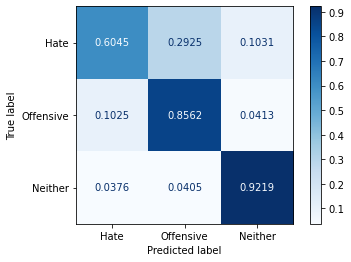

In [ ]:
plot_confusion_matrix(LR_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

In [ ]:
y_pred_LR_s = LR_classifier.predict(x_test)
print(classification_report(y_test, y_pred_LR_s, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.29      0.60      0.39       359
   Offensive       0.97      0.86      0.91      4800
     Neither       0.80      0.92      0.86      1037

    accuracy                           0.85      6196
   macro avg       0.69      0.79      0.72      6196
weighted avg       0.90      0.85      0.87      6196



## Random Forest

In [ ]:
RF_classifier = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
CV_RF_s = cross_val_score(RF_classifier, x_train_s, y_train_s, cv = 5, n_jobs = -1)
CV_RF_s.mean()

0.9614315496872828

In [ ]:
RF_classifier.fit(x_train_s, y_train_s)

RandomForestClassifier(n_jobs=-1, random_state=0)

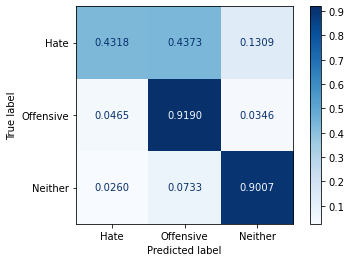

In [ ]:
plot_confusion_matrix(RF_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

In [ ]:
y_pred_RF_s = RF_classifier.predict(x_test)
print(classification_report(y_test, y_pred_RF_s, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.38      0.43      0.41       359
   Offensive       0.95      0.92      0.93      4800
     Neither       0.81      0.90      0.86      1037

    accuracy                           0.89      6196
   macro avg       0.72      0.75      0.73      6196
weighted avg       0.89      0.89      0.89      6196



## SVM Linear

In [ ]:
LSVM_classifier = LinearSVC(random_state = 0, max_iter = 100000)
params = {'C' : [0.1,1,10,100]}
gcv_lsvm = GridSearchCV(LSVM_classifier, params, cv = 5, n_jobs = -1)
gcv_lsvm.fit(x_train_s,y_train_s)
print('Best Score : ', gcv_lsvm.best_score_)
print('Best Parameters : ', gcv_lsvm.best_params_)

Best Score :  0.9331943479268011
Best Parameters :  {'C': 100}


In [ ]:
LSVM_classifier = LinearSVC(C = 100,random_state = 0, max_iter = 1000000)

In [ ]:
LSVM_classifier.fit(x_train_s, y_train_s)

LinearSVC(C=100, max_iter=1000000, random_state=0)

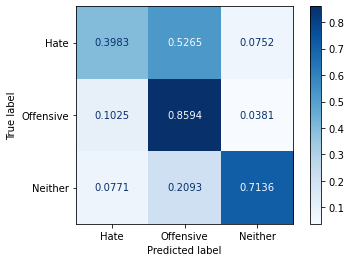

In [ ]:
plot_confusion_matrix(LSVM_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

In [ ]:
y_pred_LSVM_s = LSVM_classifier.predict(x_test)
print(classification_report(y_test, y_pred_LSVM_s, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.20      0.40      0.27       359
   Offensive       0.91      0.86      0.88      4800
     Neither       0.78      0.71      0.74      1037

    accuracy                           0.81      6196
   macro avg       0.63      0.66      0.63      6196
weighted avg       0.85      0.81      0.83      6196

